#### **Library imports**

In [248]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Hyperparams and loading data**

In [3]:
train_edges = np.load('data/train_edges.npy')
user_list = train_edges[:, 0]
item_list = train_edges[:, 1]
rating_list = train_edges[:, 2].astype('float32')

n_users = 943 
n_items = 1682
n_samples = len(rating_list)

#### **Defining collaborative filtering**

In [30]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

#### **Code for meta attack**

In [210]:
# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 0
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
lr = 50
T = 50
Delta = 5000 # 5% ~ 10K perturbations
n_factors = 64
save_results = True

# store loss results in this list and later convert to dataframe 
results = []

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []

# print hyperparam config
print('-> Learning rate: ', lr)
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, Delta * 100 // n_samples))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)

# define model and it's parameters
model = CollaborativeFiltering(n_users, n_items, n_factors)
model.to(device)
p1, p2 = model.parameters()

# for each perturbation do the following
for delta in range(Delta):

    # makes loss reproducible for each iteration in Delta
    torch.manual_seed(0)

    # reset model paramters 
    for layer in model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    model.train()

    # inner loop training process
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        results.append([delta, i, loss.item()])
        
        # compute inner parameter gradients
        p1_grad = torch.autograd.grad(loss, p1, create_graph=True)
        p2_grad = torch.autograd.grad(loss, p2, create_graph=True)

        # update inner parameters
        with torch.no_grad():
            p1_new = p1 - lr * p1_grad[0]
            p2_new = p2 - lr * p2_grad[0]
            p1.copy_(p1_new)
            p2.copy_(p2_new)
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1

        # keep track of perturbations
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())


# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
results = pd.DataFrame(results, columns = ['perturbs', 'iters', 'loss'])
perturbations = pd.DataFrame(perturbations)

# save results in CSV format
if save_results:
    results.to_csv('results/losses_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors))
    perturbations.to_csv('results/perturbations_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors))

# 1000 perturbations with T = 50 takes approximately 2 min 30 sec

-> Learning rate:  50
-> T:  50
-> Delta: 5000 (2%)
-> Embedding size:  64
-> Device:  cuda:0
-> Execution time: 00h 12m 40s


#### **Understanding impact of perturbations**

In [224]:
losses = results[results.iters == T - 1][['perturbs', 'loss']]
# losses.set_index('perturbs', inplace = True)
losses

,perturbs,loss
49,0,2.203668
99,1,2.203820
149,2,2.203969
199,3,2.204113
249,4,2.204257
...,...,...
249799,4995,2.405466
249849,4996,2.405484
249899,4997,2.405526
249949,4998,2.405528


In [251]:
perturbations

,edges,metagrad
0,26320,0.000153
1,103855,0.000149
2,134398,0.000145
3,199723,0.000145
4,40063,0.000143
...,...,...
4995,2083,0.000050
4996,158281,0.000050
4997,46445,0.000050
4998,63534,0.000050


#### **Some plots**

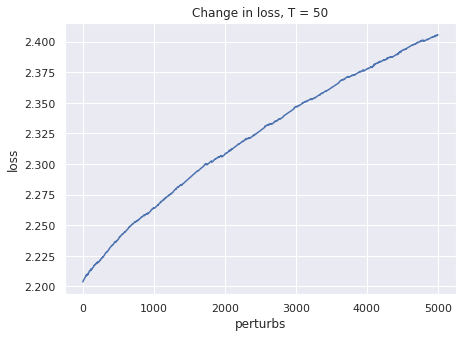

In [250]:
sns.set_theme()
plt.figure(figsize = (7, 5))
lineplot = sns.lineplot(data=losses, x="perturbs", y="loss").set_title('Change in loss, T = {}'.format(T))
fig = lineplot.get_figure()
fig.savefig('plots/losses_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors))
plt.show()